In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from tqdm import tqdm


In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=True)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
set_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
data = torch.load("./data/lstm_dataset.pth")

dataset_F = data["dataset_F"].to(device)
dataset_FA = data["dataset_FA"].to(device)
dataset_FAA = data["dataset_FAA"].to(device)
y = data["y"].to(device)

K = 10  # Set the number of folds
kf = KFold(n_splits=K, shuffle=True, random_state=42)


C:\Users\kimnal0\AppData\Local\Temp\ipykernel_23708\2973149279.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("./data/lstm_dataset.pth")


In [5]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len=10, lstm_layers=1, dropout=0):
        super(LSTMClassifier, self).__init__()
        self.seq_len = seq_len
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=lstm_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * seq_len, 1)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        batch_size, num_chains, seq_len, feature_dim = x.size()
        x = x.permute(0, 2, 1, 3).reshape(batch_size, seq_len, num_chains * feature_dim)

        # Run through LSTM and collect all time steps
        lstm_out, _ = self.lstm(x)  
        # Combine outputs from all chains
        lstm_out = lstm_out.reshape(batch_size, -1)  # Flatten the outputs
        out = self.fc(lstm_out)
        return out.squeeze()


In [6]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(inputs).squeeze()
        loss = criterion(out, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)
 

def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device) 

            outputs = model(inputs).squeeze()
            outputs = torch.sigmoid(outputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

def evaluate_with_auc(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            outputs = torch.sigmoid(outputs)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)

    return fpr, tpr, roc_auc


def get_baseline_acc(loader):
    num_true = 0
    num_samples = 0
    for inputs, labels in loader:
        num_true += int(labels.sum())
        num_samples += labels.size(0)
    return num_true / num_samples

def evaluate_with_fixed_threshold_precision(model, test_loader):
    threshold=0.5
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            outputs = torch.sigmoid(outputs)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    binary_preds = [1 if pred >= threshold else 0 for pred in all_preds]
    
    precision = precision_score(all_labels, binary_preds)
    
    return precision

def evaluate_with_fixed_threshold_recall(model, test_loader):
    threshold=0.5
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            outputs = torch.sigmoid(outputs)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    binary_preds = [1 if pred >= threshold else 0 for pred in all_preds]
    
    precision = recall_score(all_labels, binary_preds, zero_division = 0)
    
    return precision


### Function Type Only (F)

In [7]:
splits = kf.split(dataset_F)

criterion = nn.BCEWithLogitsLoss()

input_dim = 50

lr = 0.001
batch_size = 64
hidden_dim = 32
dropout_p = 0
num_layer = 1
num_epochs = 50


train_accs, test_accs = [0] * num_epochs, [0] * num_epochs
precisions, recalls = [0] * num_epochs, [0] * num_epochs

epoch_fprs = [[] for _ in range(num_epochs)]
epoch_tprs = [[] for _ in range(num_epochs)]
mean_fpr = np.linspace(0, 1, 50)

for fold, (train_idx, test_idx) in tqdm(enumerate(splits)):
    X_train, X_test = dataset_F[train_idx], dataset_F[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)
    
    set_seed(42)
    model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, lstm_layers=num_layer, dropout=dropout_p).to(device)

    optimizer = optim.Adam(model.parameters(), lr = lr)


    for epoch in range(num_epochs):
        loss = train(model, train_loader, criterion, optimizer)
        train_acc = evaluate(model, train_loader)
        test_acc = evaluate(model, test_loader)
        fpr, tpr, _ = evaluate_with_auc(model, test_loader)
        precision = evaluate_with_fixed_threshold_precision(model, test_loader)
        recall = evaluate_with_fixed_threshold_recall(model, test_loader)

        train_accs[epoch] += train_acc
        test_accs[epoch] += test_acc
        precisions[epoch] += precision
        recalls[epoch] += recall

        epoch_fprs[epoch].append(fpr)
        epoch_tprs[epoch].append(np.interp(mean_fpr, fpr, tpr))  
        epoch_tprs[epoch][-1][0] = 0.0  


10it [00:21,  2.17s/it]


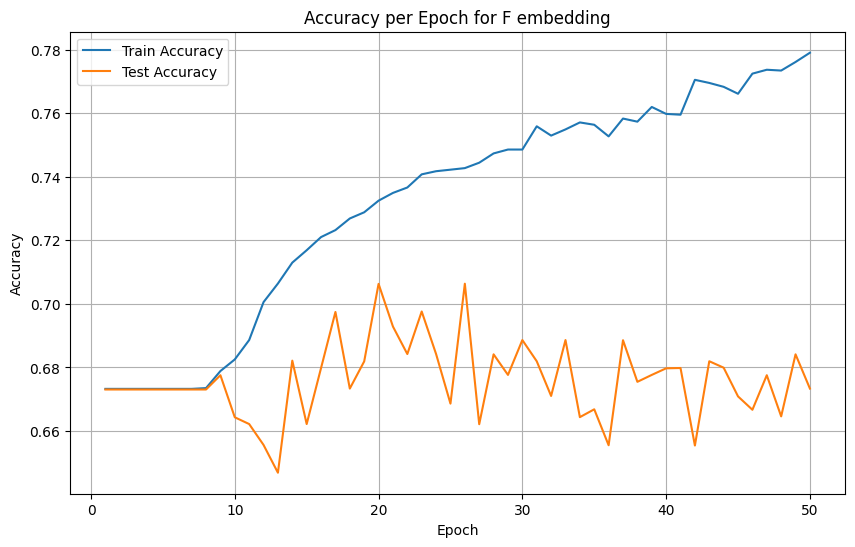

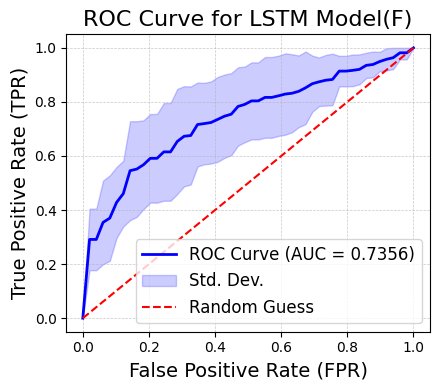

Epoch = 25
Best_mean_accuracy: 0.7063
Best mean_roc_auc: 0.7356
Best mean_precision: 0.7570
Best mean_recall: 0.8302


In [15]:
mean_train_accs = [acc / 10 for acc in train_accs]
mean_test_accs = [acc / 10 for acc in test_accs]
mean_precisions = [pre / 10 for pre in precisions]
mean_recalls = [recall / 10 for recall in recalls]

best_mean_accuracy = max(mean_test_accs)
best_epoch = mean_test_accs.index(best_mean_accuracy)
mean_tpr = np.mean(epoch_tprs[best_epoch], axis=0)
std_tpr = np.std(epoch_tprs[best_epoch], axis=0)
mean_tpr[-1] = 1.0
mean_roc_auc = auc(mean_fpr, mean_tpr)

# Plot accuracy graphs over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), mean_train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), mean_test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy per Epoch for F embedding')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC Curve for the best epoch
plt.figure(figsize=(4.5, 4))
plt.plot(mean_fpr, mean_tpr, label=f'ROC Curve (AUC = {mean_roc_auc:.4f})', color='blue', linewidth=2)
plt.fill_between(mean_fpr, np.maximum(mean_tpr-std_tpr, 0), np.minimum(mean_tpr+std_tpr, 1), color = 'blue', alpha=0.2, label = 'Std. Dev.')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1.5, label='Random Guess')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title(f'ROC Curve for LSTM Model(F)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.show()
    
print(f"Epoch = {best_epoch}")
print(f"Best_mean_accuracy: {mean_test_accs[best_epoch]:.4f}")
print(f"Best mean_roc_auc: {mean_roc_auc:.4f}")
print(f"Best mean_precision: {mean_precisions[best_epoch]:.4f}")
print(f"Best mean_recall: {mean_recalls[best_epoch]:.4f}")

### Function Type and Arguments (F+A)

In [16]:
splits = kf.split(dataset_FA)

criterion = nn.BCEWithLogitsLoss()

input_dim = 330

lr = 0.001
batch_size = 16
hidden_dim = 128
dropout_p = 0.5
num_layer = 2
num_epochs = 50

roc_aucs, precisions, recalls = [0] * num_epochs, [0] * num_epochs, [0] * num_epochs
train_accs, test_accs = [0] * num_epochs, [0] * num_epochs
for fold, (train_idx, test_idx) in tqdm(enumerate(splits)):

    X_train, X_test = dataset_FA[train_idx], dataset_FA[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    # print(f"X_train shape: {X_train.shape}, y shape: {y.shape}")

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)
    
    set_seed(42)
    model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, lstm_layers=num_layer, dropout=dropout_p).to(device)

    optimizer = optim.Adam(model.parameters(), lr = lr)


    for epoch in range(num_epochs):
        loss = train(model, train_loader, criterion, optimizer)
        train_acc = evaluate(model, train_loader)
        test_acc = evaluate(model, test_loader)
        fpr, tpr, _ = evaluate_with_auc(model, test_loader)
        precision = evaluate_with_fixed_threshold_precision(model, test_loader)
        recall = evaluate_with_fixed_threshold_recall(model, test_loader)

        train_accs[epoch] += train_acc
        test_accs[epoch] += test_acc
        precisions[epoch] += precision
        recalls[epoch] += recall

        epoch_fprs[epoch].append(fpr)
        epoch_tprs[epoch].append(np.interp(mean_fpr, fpr, tpr))  
        epoch_tprs[epoch][-1][0] = 0.0  


10it [01:01,  6.20s/it]


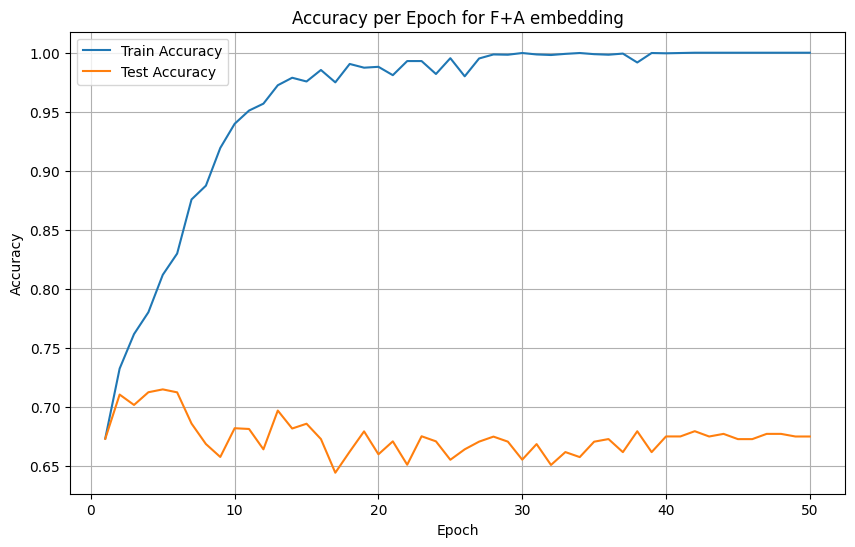

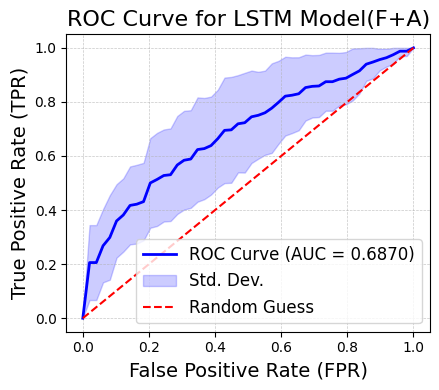

Epoch = 4
Best_mean_accuracy: 0.7149
Best mean_roc_auc: 0.6870
Best mean_precision: 0.7662
Best mean_recall: 0.8268


In [17]:
mean_train_accs = [acc / 10 for acc in train_accs]
mean_test_accs = [acc / 10 for acc in test_accs]
mean_precisions = [pre / 10 for pre in precisions]
mean_recalls = [recall / 10 for recall in recalls]

best_mean_accuracy = max(mean_test_accs)
best_epoch = mean_test_accs.index(best_mean_accuracy)
mean_tpr = np.mean(epoch_tprs[best_epoch], axis=0)
std_tpr = np.std(epoch_tprs[best_epoch], axis=0)
mean_tpr[-1] = 1.0
mean_roc_auc = auc(mean_fpr, mean_tpr)

# Plot accuracy graphs over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), mean_train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), mean_test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy per Epoch for F+A embedding')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC Curve for the best epoch
plt.figure(figsize=(4.5, 4))
plt.plot(mean_fpr, mean_tpr, label=f'ROC Curve (AUC = {mean_roc_auc:.4f})', color='blue', linewidth=2)
plt.fill_between(mean_fpr, np.maximum(mean_tpr-std_tpr, 0), np.minimum(mean_tpr+std_tpr, 1), color = 'blue', alpha=0.2, label = 'Std. Dev.')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1.5, label='Random Guess')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title(f'ROC Curve for LSTM Model(F+A)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.show()
    
print(f"Epoch = {best_epoch}")
print(f"Best_mean_accuracy: {mean_test_accs[best_epoch]:.4f}")
print(f"Best mean_roc_auc: {mean_roc_auc:.4f}")
print(f"Best mean_precision: {mean_precisions[best_epoch]:.4f}")
print(f"Best mean_recall: {mean_recalls[best_epoch]:.4f}")

### Function Type, Arguments and Answer (F+A+A)

In [20]:
splits = kf.split(dataset_FAA)

criterion = nn.BCEWithLogitsLoss()

input_dim = 330

lr = 0.001
batch_size = 32
hidden_dim = 32
dropout_p = 0
num_layer = 1
num_epochs = 50

train_accs, test_accs = [0] * num_epochs, [0] * num_epochs
precisions, recalls = [0] * num_epochs, [0] * num_epochs

epoch_fprs = [[] for _ in range(num_epochs)]
epoch_tprs = [[] for _ in range(num_epochs)]
mean_fpr = np.linspace(0, 1, 50)

for fold, (train_idx, test_idx) in tqdm(enumerate(splits)):

    X_train, X_test = dataset_FAA[train_idx], dataset_FAA[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    # print(f"X_train shape: {X_train.shape}, y shape: {y.shape}")

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)
    
    set_seed(42)
    model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, lstm_layers=num_layer, dropout=dropout_p, seq_len = 11).to(device)

    optimizer = optim.Adam(model.parameters(), lr = lr)


    for epoch in range(num_epochs):
        loss = train(model, train_loader, criterion, optimizer)
        train_acc = evaluate(model, train_loader)
        test_acc = evaluate(model, test_loader)
        fpr, tpr, _ = evaluate_with_auc(model, test_loader)
        precision = evaluate_with_fixed_threshold_precision(model, test_loader)
        recall = evaluate_with_fixed_threshold_recall(model, test_loader)

        train_accs[epoch] += train_acc
        test_accs[epoch] += test_acc
        precisions[epoch] += precision
        recalls[epoch] += recall

        epoch_fprs[epoch].append(fpr)
        epoch_tprs[epoch].append(np.interp(mean_fpr, fpr, tpr))  
        epoch_tprs[epoch][-1][0] = 0.0  

10it [00:34,  3.47s/it]


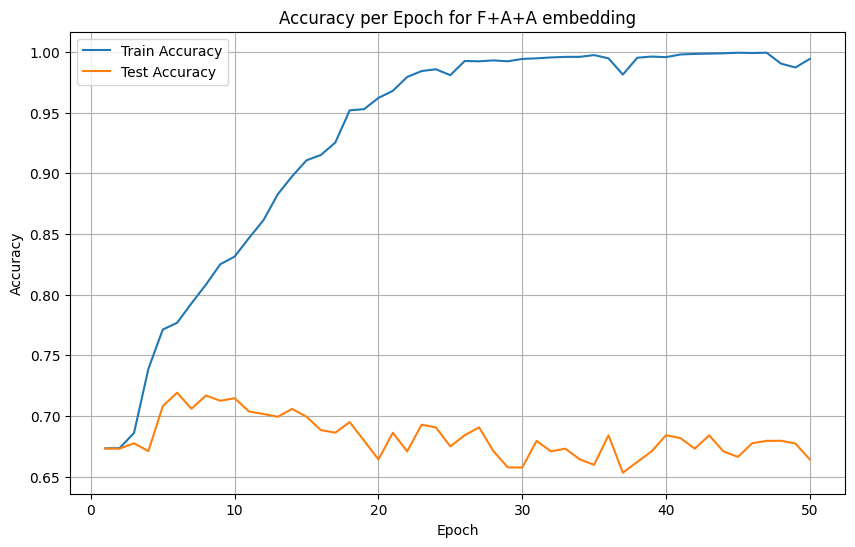

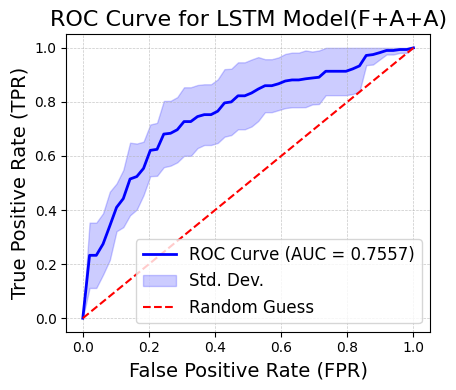

Epoch = 5
Best_mean_accuracy: 0.7191
Best mean_roc_auc: 0.7557
Best mean_precision: 0.7711
Best mean_recall: 0.8272


: 

In [ ]:
mean_train_accs = [acc / 10 for acc in train_accs]
mean_test_accs = [acc / 10 for acc in test_accs]
mean_precisions = [pre / 10 for pre in precisions]
mean_recalls = [recall / 10 for recall in recalls]

best_mean_accuracy = max(mean_test_accs)
best_epoch = mean_test_accs.index(best_mean_accuracy)
mean_tpr = np.mean(epoch_tprs[best_epoch], axis=0)
std_tpr = np.std(epoch_tprs[best_epoch], axis=0)
mean_tpr[-1] = 1.0
mean_roc_auc = auc(mean_fpr, mean_tpr)

# Plot accuracy graphs over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), mean_train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), mean_test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy per Epoch for F+A+A embedding')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC Curve for the best epoch
plt.figure(figsize=(4.5, 4))
plt.plot(mean_fpr, mean_tpr, label=f'ROC Curve (AUC = {mean_roc_auc:.4f})', color='blue', linewidth=2)
plt.fill_between(mean_fpr, np.maximum(mean_tpr-std_tpr, 0), np.minimum(mean_tpr+std_tpr, 1), color = 'blue', alpha=0.2, label = 'Std. Dev.')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1.5, label='Random Guess')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title(f'ROC Curve for LSTM Model(F+A+A)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("./figures/Figure_lstm_FAA_ROC_AUC.pdf", format="pdf", dpi=300)

plt.show()
    
print(f"Epoch = {best_epoch}")
print(f"Best_mean_accuracy: {mean_test_accs[best_epoch]:.4f}")
print(f"Best mean_roc_auc: {mean_roc_auc:.4f}")
print(f"Best mean_precision: {mean_precisions[best_epoch]:.4f}")
print(f"Best mean_recall: {mean_recalls[best_epoch]:.4f}")